In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from shutil import rmtree
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm, trange
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.datasets import ImageFolder

from predictors.alexnet import Alexnet
from predictors.half_alexnet import HalfAlexnet

from datasets import CIFAR10, ProxyDataset

%matplotlib inline

In [3]:
LR = 0.001
EPOCHS = 200
BATCH_SIZE = 32
CONFIDENCE_TH = 0.8

DATASET_PATH = '.'
TEMP_BEST_MODEL = 'euclidean_simple'

# Set random seed for replicating testing results
RANDOM_SEED = 0
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Teacher
teacher_model = Alexnet(name=None, n_outputs=10)

ckpt_path = 'checkpoints/teacher_alexnet_for_cifar10_state_dict'
teacher_model.load_state_dict(torch.load(ckpt_path, map_location=device))
teacher_model.eval()
teacher_model = teacher_model.to(device)

In [5]:
# Define dataset
label_mapper = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}
label_mapper_inv = {v:k for k,v in label_mapper.items()}

# Get images paths and labels
images = []
labels = []

folders_path = os.path.join(DATASET_PATH,'images_generated')
for folder in os.listdir(folders_path):
    if 'imagenet' in folder:
      continue
    class_path = os.path.join(folders_path,folder)
    images_names = os.listdir(class_path)
    
    for image_name in images_names:
        images.append(os.path.join(class_path,image_name))
        labels.append(label_mapper[folder])

In [6]:
proxy_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

proxy_dataset = ProxyDataset(images, labels, proxy_transforms, True)
proxy_dataloader  = DataLoader(proxy_dataset,  batch_size=BATCH_SIZE)

# Obtain teacher predictions
filtered_images = []
filtered_labels = []
filtered_soft_labels = []

with torch.no_grad():
    for img,label,path,_ in tqdm(proxy_dataloader):
        img = img.to(device=device)
        label = label.to(device=device)

        logits = teacher_model(img)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)

        filtered_images.extend(list(path))
        filtered_labels.extend(y_hat.tolist())
        filtered_soft_labels.extend(pred)
        
# Display results of filtering
print(f'A total of {len(filtered_images)} remained out of {len(proxy_dataset)}')
print()
counter_per_class = {v:0 for k,v in label_mapper.items()}
for label in filtered_labels:
    counter_per_class[label] += 1
for clasa in counter_per_class:
    print(f'Class {clasa}({label_mapper_inv[clasa]}) has {counter_per_class[clasa]} entries')

  0%|          | 0/1600 [00:00<?, ?it/s]

A total of 51200 remained out of 51200

Class 0(airplane) has 6384 entries
Class 1(automobile) has 5145 entries
Class 2(bird) has 4795 entries
Class 3(cat) has 5331 entries
Class 4(deer) has 5571 entries
Class 5(dog) has 4286 entries
Class 6(frog) has 4553 entries
Class 7(horse) has 5025 entries
Class 8(ship) has 5178 entries
Class 9(truck) has 4932 entries


In [7]:
# Define the student model
student_model = HalfAlexnet(name=None, n_outputs=10)

path_to_save = 'pretrained_student.pt'
if torch.cuda.is_available():
    student_model.load_state_dict(torch.load(path_to_save))
else:
    student_model.load_state_dict(torch.load(path_to_save, map_location ='cpu'))
student_model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=LR)

# Define loss function
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [8]:
try:
  # raise
  # Do a stratified split of the data
  NO_IMGS_TO_USE = 32768
  
  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
      train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels, random_state=RANDOM_SEED)  

  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
      train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=0.8, stratify=filtered_labels_subset, random_state=RANDOM_SEED)
  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels, random_state=RANDOM_SEED)
except:
  # For small datasets 
  print('Small dataset')
  NO_IMGS_TO_USE = 60
  NO_TRAIN_IMGS = 40

  """ DEV - train_test_split fails, need to manually introduce 1 sample
  for i in range(len(filtered_labels)-1,-1,-1):
    if filtered_labels[i] == 5:
      img_dev = filtered_images[i]
      soft_label_dev = filtered_soft_labels[i]
      break
  """

  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
    train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels, random_state=RANDOM_SEED)  
  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
    train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=NO_TRAIN_IMGS, stratify=filtered_labels_subset, random_state=RANDOM_SEED)
  
  """ DEV - interchange an image
  for i in range(len(validation_images)):
    if validation_labels[i] == 0:
      validation_images[i] = img_dev
      validation_labels[i] = 5
      validation_soft_labels[i] = soft_label_dev
      break
  """

  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)

In [9]:
# Define the transformations
train_transforms = T.Compose([
    T.Resize((32,32)),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize((0.5,), (0.5,))
])
valid_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

# Define the proxy datasets
proxy_train_dataset = ProxyDataset(train_images, train_labels, train_transforms, False, train_soft_labels)
proxy_valid_dataset = ProxyDataset(valid_images, valid_labels, valid_transforms, False, valid_soft_labels)
proxy_test_dataset  = ProxyDataset(test_images,  test_labels,  valid_transforms, False, test_soft_labels)

# Define the proxy dataloaders
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(proxy_valid_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(proxy_test_dataset,  batch_size=BATCH_SIZE)

# Define true dataset
true_dataset = CIFAR10(input_size = 32)

validate_on_trueds = True
if validate_on_trueds:
    true_valid_ds = true_dataset.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Class for early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):
      self.tolerance = tolerance
      self.min_delta = min_delta
      self.counter = 0
      self.min_valid_loss = np.inf
      self.early_stop = False

    def __call__(self, validation_loss):
      if validation_loss < self.min_valid_loss:
        self.min_valid_loss = validation_loss
        self.counter = 0
      elif validation_loss > self.min_valid_loss + self.min_delta:
        self.counter +=1
        
        if self.counter >= self.tolerance:  
            self.early_stop = True

In [11]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.05)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

best_accuracy = 0.0
# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    # Save best model
    valid_proxy_acc = acc/len(proxy_valid_dataset)
    if valid_proxy_acc > best_accuracy:
        best_accuracy = valid_proxy_acc
        torch.save(student_model.state_dict(), f'temp_models/{TEMP_BEST_MODEL}.pt')
        print(f'Saved at epoch {epoch}')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

student_model.load_state_dict(torch.load(f'temp_models/{TEMP_BEST_MODEL}.pt'))

  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5616
validation_accuracy on proxy = 82.79%
Saved at epoch 0
validation_loss on true ds = 1.3525
validation_accuracy on true ds = 52.56%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5403
validation_accuracy on proxy = 83.64%
Saved at epoch 1
validation_loss on true ds = 1.3960
validation_accuracy on true ds = 53.21%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4908
validation_accuracy on proxy = 85.47%
Saved at epoch 2
validation_loss on true ds = 1.2179
validation_accuracy on true ds = 57.89%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4828
validation_accuracy on proxy = 85.32%
validation_loss on true ds = 1.2054
validation_accuracy on true ds = 58.41%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4799
validation_accuracy on proxy = 85.51%
Saved at epoch 4
validation_loss on true ds = 1.1242
validation_accuracy on true ds = 61.21%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4941
validation_accuracy on proxy = 85.66%
Saved at epoch 5
validation_loss on true ds = 1.1516
validation_accuracy on true ds = 60.64%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4723
validation_accuracy on proxy = 85.87%
Saved at epoch 6
validation_loss on true ds = 1.0733
validation_accuracy on true ds = 62.77%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4794
validation_accuracy on proxy = 86.63%
Saved at epoch 7
validation_loss on true ds = 1.0596
validation_accuracy on true ds = 63.19%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4562
validation_accuracy on proxy = 86.18%
validation_loss on true ds = 1.0709
validation_accuracy on true ds = 63.43%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4661
validation_accuracy on proxy = 86.27%
validation_loss on true ds = 1.1415
validation_accuracy on true ds = 61.22%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4598
validation_accuracy on proxy = 86.57%
validation_loss on true ds = 1.0084
validation_accuracy on true ds = 65.22%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4646
validation_accuracy on proxy = 85.32%
validation_loss on true ds = 1.0849
validation_accuracy on true ds = 62.78%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4424
validation_accuracy on proxy = 86.57%
validation_loss on true ds = 0.9995
validation_accuracy on true ds = 65.13%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4357
validation_accuracy on proxy = 86.21%
validation_loss on true ds = 1.0041
validation_accuracy on true ds = 65.42%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4571
validation_accuracy on proxy = 86.33%
validation_loss on true ds = 0.9869
validation_accuracy on true ds = 66.51%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4475
validation_accuracy on proxy = 86.70%
Saved at epoch 15
validation_loss on true ds = 1.1144
validation_accuracy on true ds = 63.01%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4491
validation_accuracy on proxy = 86.30%
validation_loss on true ds = 0.9746
validation_accuracy on true ds = 67.08%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4290
validation_accuracy on proxy = 86.88%
Saved at epoch 17
validation_loss on true ds = 0.9532
validation_accuracy on true ds = 67.65%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4264
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 0.9520
validation_accuracy on true ds = 67.61%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4272
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9703
validation_accuracy on true ds = 66.61%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4441
validation_accuracy on proxy = 85.87%
validation_loss on true ds = 0.9720
validation_accuracy on true ds = 66.27%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4559
validation_accuracy on proxy = 86.36%
validation_loss on true ds = 1.0636
validation_accuracy on true ds = 63.97%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4239
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9323
validation_accuracy on true ds = 67.37%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4447
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9570
validation_accuracy on true ds = 66.94%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4390
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9598
validation_accuracy on true ds = 67.29%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4472
validation_accuracy on proxy = 86.91%
Saved at epoch 25
validation_loss on true ds = 0.9814
validation_accuracy on true ds = 66.75%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4281
validation_accuracy on proxy = 86.97%
Saved at epoch 26
validation_loss on true ds = 0.9460
validation_accuracy on true ds = 67.73%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4287
validation_accuracy on proxy = 86.79%
validation_loss on true ds = 0.9452
validation_accuracy on true ds = 68.15%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4603
validation_accuracy on proxy = 86.12%
validation_loss on true ds = 0.9628
validation_accuracy on true ds = 67.27%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4421
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9481
validation_accuracy on true ds = 68.36%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4280
validation_accuracy on proxy = 87.03%
Saved at epoch 30
validation_loss on true ds = 0.9186
validation_accuracy on true ds = 69.16%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4236
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9221
validation_accuracy on true ds = 68.64%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4564
validation_accuracy on proxy = 86.39%
validation_loss on true ds = 0.9268
validation_accuracy on true ds = 69.11%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4351
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9576
validation_accuracy on true ds = 68.23%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4485
validation_accuracy on proxy = 86.39%
validation_loss on true ds = 0.9401
validation_accuracy on true ds = 68.19%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4255
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 0.9523
validation_accuracy on true ds = 68.04%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4278
validation_accuracy on proxy = 86.85%
validation_loss on true ds = 0.8922
validation_accuracy on true ds = 69.94%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4331
validation_accuracy on proxy = 86.91%
validation_loss on true ds = 0.8910
validation_accuracy on true ds = 70.56%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4382
validation_accuracy on proxy = 87.31%
Saved at epoch 38
validation_loss on true ds = 0.9824
validation_accuracy on true ds = 67.17%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4408
validation_accuracy on proxy = 86.91%
validation_loss on true ds = 0.9922
validation_accuracy on true ds = 67.24%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4410
validation_accuracy on proxy = 86.27%
validation_loss on true ds = 0.9536
validation_accuracy on true ds = 66.85%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4250
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9056
validation_accuracy on true ds = 69.29%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4458
validation_accuracy on proxy = 86.30%
validation_loss on true ds = 0.9226
validation_accuracy on true ds = 69.46%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4454
validation_accuracy on proxy = 86.97%
validation_loss on true ds = 0.9744
validation_accuracy on true ds = 68.62%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4389
validation_accuracy on proxy = 86.91%
validation_loss on true ds = 0.9435
validation_accuracy on true ds = 69.32%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4381
validation_accuracy on proxy = 87.00%
validation_loss on true ds = 0.8940
validation_accuracy on true ds = 70.28%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4449
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9386
validation_accuracy on true ds = 69.49%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4354
validation_accuracy on proxy = 87.24%
validation_loss on true ds = 0.9174
validation_accuracy on true ds = 69.22%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4332
validation_accuracy on proxy = 87.15%
validation_loss on true ds = 0.9540
validation_accuracy on true ds = 68.82%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4392
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9403
validation_accuracy on true ds = 68.97%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4426
validation_accuracy on proxy = 86.57%
validation_loss on true ds = 0.9244
validation_accuracy on true ds = 69.60%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4407
validation_accuracy on proxy = 86.91%
validation_loss on true ds = 0.9159
validation_accuracy on true ds = 69.40%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4377
validation_accuracy on proxy = 86.91%
validation_loss on true ds = 0.9278
validation_accuracy on true ds = 69.32%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4437
validation_accuracy on proxy = 86.70%
validation_loss on true ds = 0.9926
validation_accuracy on true ds = 67.78%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4405
validation_accuracy on proxy = 87.06%
validation_loss on true ds = 0.9663
validation_accuracy on true ds = 68.96%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4488
validation_accuracy on proxy = 86.73%
validation_loss on true ds = 0.9376
validation_accuracy on true ds = 69.87%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4511
validation_accuracy on proxy = 87.03%
validation_loss on true ds = 0.9610
validation_accuracy on true ds = 68.61%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4397
validation_accuracy on proxy = 87.06%
validation_loss on true ds = 0.9093
validation_accuracy on true ds = 70.40%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4427
validation_accuracy on proxy = 87.12%
validation_loss on true ds = 0.9160
validation_accuracy on true ds = 69.99%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4507
validation_accuracy on proxy = 87.06%
validation_loss on true ds = 0.9158
validation_accuracy on true ds = 69.84%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4452
validation_accuracy on proxy = 87.40%
Saved at epoch 60
validation_loss on true ds = 0.9411
validation_accuracy on true ds = 69.93%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4661
validation_accuracy on proxy = 86.51%
validation_loss on true ds = 0.9489
validation_accuracy on true ds = 69.76%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4559
validation_accuracy on proxy = 87.15%
validation_loss on true ds = 0.9538
validation_accuracy on true ds = 69.23%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4525
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9137
validation_accuracy on true ds = 69.20%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4540
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9651
validation_accuracy on true ds = 68.93%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4607
validation_accuracy on proxy = 87.15%
validation_loss on true ds = 0.9866
validation_accuracy on true ds = 68.47%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4526
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9225
validation_accuracy on true ds = 69.31%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4459
validation_accuracy on proxy = 87.15%
validation_loss on true ds = 0.9026
validation_accuracy on true ds = 70.09%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4413
validation_accuracy on proxy = 87.15%
validation_loss on true ds = 0.9454
validation_accuracy on true ds = 68.83%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4443
validation_accuracy on proxy = 87.09%
validation_loss on true ds = 0.8906
validation_accuracy on true ds = 70.59%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4485
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9517
validation_accuracy on true ds = 68.80%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4525
validation_accuracy on proxy = 86.36%
validation_loss on true ds = 0.9629
validation_accuracy on true ds = 68.84%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4535
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9092
validation_accuracy on true ds = 70.43%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4614
validation_accuracy on proxy = 86.85%
validation_loss on true ds = 0.9382
validation_accuracy on true ds = 69.51%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4578
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9210
validation_accuracy on true ds = 70.39%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4545
validation_accuracy on proxy = 86.33%
validation_loss on true ds = 1.0173
validation_accuracy on true ds = 67.17%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4628
validation_accuracy on proxy = 86.88%
validation_loss on true ds = 0.9177
validation_accuracy on true ds = 70.52%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4532
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9662
validation_accuracy on true ds = 68.58%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4711
validation_accuracy on proxy = 86.94%
validation_loss on true ds = 1.0157
validation_accuracy on true ds = 67.79%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4565
validation_accuracy on proxy = 86.79%
validation_loss on true ds = 0.9161
validation_accuracy on true ds = 69.57%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4690
validation_accuracy on proxy = 86.85%
validation_loss on true ds = 0.9418
validation_accuracy on true ds = 69.60%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4741
validation_accuracy on proxy = 85.96%
validation_loss on true ds = 0.9581
validation_accuracy on true ds = 69.27%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4702
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 0.9598
validation_accuracy on true ds = 69.82%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4752
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 1.0144
validation_accuracy on true ds = 67.27%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4517
validation_accuracy on proxy = 87.15%
validation_loss on true ds = 0.9052
validation_accuracy on true ds = 70.34%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4724
validation_accuracy on proxy = 87.06%
validation_loss on true ds = 0.9502
validation_accuracy on true ds = 70.02%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4670
validation_accuracy on proxy = 86.60%
validation_loss on true ds = 0.9489
validation_accuracy on true ds = 69.44%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4599
validation_accuracy on proxy = 87.06%
validation_loss on true ds = 0.9281
validation_accuracy on true ds = 69.61%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4563
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9721
validation_accuracy on true ds = 68.53%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4512
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9739
validation_accuracy on true ds = 69.24%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4574
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9704
validation_accuracy on true ds = 69.23%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4642
validation_accuracy on proxy = 86.57%
validation_loss on true ds = 0.9254
validation_accuracy on true ds = 71.04%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4561
validation_accuracy on proxy = 86.57%
validation_loss on true ds = 0.9450
validation_accuracy on true ds = 69.94%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4646
validation_accuracy on proxy = 86.51%
validation_loss on true ds = 0.9303
validation_accuracy on true ds = 70.40%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4750
validation_accuracy on proxy = 86.21%
validation_loss on true ds = 0.9878
validation_accuracy on true ds = 68.92%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4568
validation_accuracy on proxy = 86.94%
validation_loss on true ds = 0.9644
validation_accuracy on true ds = 69.59%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4581
validation_accuracy on proxy = 87.31%
validation_loss on true ds = 0.9444
validation_accuracy on true ds = 69.73%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4572
validation_accuracy on proxy = 87.00%
validation_loss on true ds = 0.9567
validation_accuracy on true ds = 69.67%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4673
validation_accuracy on proxy = 86.36%
validation_loss on true ds = 0.9708
validation_accuracy on true ds = 69.25%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4615
validation_accuracy on proxy = 86.79%
validation_loss on true ds = 0.9582
validation_accuracy on true ds = 69.97%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4653
validation_accuracy on proxy = 86.94%
validation_loss on true ds = 0.9586
validation_accuracy on true ds = 69.65%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4610
validation_accuracy on proxy = 87.06%
validation_loss on true ds = 0.9646
validation_accuracy on true ds = 69.08%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4697
validation_accuracy on proxy = 86.70%
validation_loss on true ds = 1.0092
validation_accuracy on true ds = 67.84%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4508
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9498
validation_accuracy on true ds = 69.44%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4689
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9814
validation_accuracy on true ds = 69.11%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4862
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9587
validation_accuracy on true ds = 69.88%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4642
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9499
validation_accuracy on true ds = 69.85%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4708
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.9648
validation_accuracy on true ds = 69.41%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4535
validation_accuracy on proxy = 87.49%
Saved at epoch 108
validation_loss on true ds = 0.9482
validation_accuracy on true ds = 69.32%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4721
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 0.9339
validation_accuracy on true ds = 70.20%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4790
validation_accuracy on proxy = 86.94%
validation_loss on true ds = 0.9866
validation_accuracy on true ds = 69.01%
We are at epoch 110


<All keys matched successfully>

In [12]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
student_model.return_feature_domain = False
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            if a == p:
                acc_per_class[a][0] += 1 # correct predictions
            acc_per_class[a][1] += 1     # total number 
            acc_per_class[p][2] += 1     # predictions of class
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: correct_pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9482
test_accuracy = 69.32%

Class airplane: correct_pred=711, actual=1000 => acc=71.10%, total_pred=974
Class automobile: correct_pred=782, actual=1000 => acc=78.20%, total_pred=897
Class bird: correct_pred=602, actual=1000 => acc=60.20%, total_pred=1011
Class cat: correct_pred=657, actual=1000 => acc=65.70%, total_pred=1464
Class deer: correct_pred=623, actual=1000 => acc=62.30%, total_pred=891
Class dog: correct_pred=646, actual=1000 => acc=64.60%, total_pred=1112
Class frog: correct_pred=710, actual=1000 => acc=71.00%, total_pred=908
Class horse: correct_pred=664, actual=1000 => acc=66.40%, total_pred=856
Class ship: correct_pred=747, actual=1000 => acc=74.70%, total_pred=899
Class truck: correct_pred=790, actual=1000 => acc=79.00%, total_pred=988


In [13]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            if a == p:
                acc_per_class[a][0] += 1
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: correct_pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9077
test_accuracy = 70.13%

Class airplane: correct_pred=750, actual=1038 => acc=72.25%, total_pred=974
Class automobile: correct_pred=785, actual=1002 => acc=78.34%, total_pred=897
Class bird: correct_pred=608, actual=965 => acc=63.01%, total_pred=1011
Class cat: correct_pred=637, actual=938 => acc=67.91%, total_pred=1464
Class deer: correct_pred=650, actual=1108 => acc=58.66%, total_pred=891
Class dog: correct_pred=631, actual=913 => acc=69.11%, total_pred=1112
Class frog: correct_pred=717, actual=996 => acc=71.99%, total_pred=908
Class horse: correct_pred=689, actual=1063 => acc=64.82%, total_pred=856
Class ship: correct_pred=734, actual=939 => acc=78.17%, total_pred=899
Class truck: correct_pred=812, actual=1038 => acc=78.23%, total_pred=988


In [14]:
# Redefine training dataset and dataloader with no augmentation
proxy_train_dataset = ProxyDataset(train_images, train_labels, valid_transforms, False, train_soft_labels)
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=False)


student_model.return_feature_domain = True

if os.path.exists('images_db'):
  rmtree('images_db')
db_path = 'images_db'
images_path = os.path.join(db_path,'images')
labels_path = os.path.join(db_path,'labels')

images_db = []
labels_db = []

if not os.path.exists('images_db'):
  os.makedirs(db_path)
  os.makedirs(images_path)
  os.makedirs(labels_path)

  for i in range(10):
    os.makedirs(os.path.join(images_path,f'class{i}'))
    os.makedirs(os.path.join(labels_path,f'class{i}'))

# Create the database
student_model.eval()
with torch.no_grad():
  # for dataloader in [train_dataloader, valid_dataloader, test_dataloader]:
  for dataloader in [train_dataloader]:
    for x,y,soft_y in dataloader:
      x = x.to(device=device)

      _,latent_fm = student_model(x)

      for i in range(latent_fm.shape[0]):
        # label = y[i].item()
        # path_image = f'{images_path}/class{label}'
        # path_label = f'{labels_path}/class{label}'
        # idx = len(os.listdir(path_image))
        # torch.save(latent_fm[i].cpu(), f'{path_image}/t{idx}.pt')
        # torch.save(soft_y[i].cpu(), f'{path_label}/t{idx}.pt')

        images_db.append(latent_fm[i])
        labels_db.append(soft_y[i])

In [15]:
class DBDataset(Dataset):
  def __init__(self, images_db, labels_db):
    self.images_db = images_db
    self.labels_db = labels_db

  def __len__(self):
    return len(self.images_db)

  def __getitem__(self, idx):
    image = self.images_db[idx]
    label = self.labels_db[idx]

    return image, label

db_dataset = DBDataset(images_db=images_db, labels_db=labels_db)
db_dataloader = DataLoader(db_dataset, batch_size=128, shuffle=False)

In [16]:
proxy_unused_dataset  = ProxyDataset(filtered_images_unused,  filtered_labels_unused,  valid_transforms, True, filtered_soft_labels_unused)

In [17]:
estimations = []
ground_truth = []

student_model.eval()
with torch.no_grad():
  for i in trange(len(proxy_unused_dataset)):
    image, label, image_path, soft_label = proxy_unused_dataset[i]
    image = image.to(device=device)

    _,latent_fm = student_model(image.unsqueeze(dim=0))

    # Calculate distances
    distances = torch.zeros(size=(len(db_dataset),), device=device)
    for j, (img_db, softl_db) in enumerate(db_dataloader):
      img_db = img_db.to(device=device)
      
      dist = (img_db - latent_fm).pow(2).sum(dim=(-1,-2,-3)).sqrt()
      
      distances[j*128:(j+1)*128] = dist
      
    smallest_d, smallest_d_indices = torch.topk(distances, k=3, largest=False)
    closest_slabels = torch.vstack([db_dataset[l][1] for l in smallest_d_indices])
    
    estimated_soft_label = closest_slabels.mean(0)
    estimated_hard_label = estimated_soft_label.argmax().item()
    
    # print(f'Ground truth soft_label = {soft_label}')
    # print(f'Estimated soft_label = {estimated_soft_label}')
    # print(f'Ground truth hard_label = {label}')
    # print(f'Estimated hard_label = {estimated_hard_label}')
    
    # print(f'Smallest 3 distances: {smallest_d}')
    # print(f'Smallest 3 indices: {smallest_d_indices}')
    # print(f'Closest 3 slabels = {closest_slabels}')
    
    train_images.append(image_path)
    train_labels.append(estimated_hard_label)
    train_soft_labels.append(estimated_soft_label)

    estimations.append(estimated_hard_label)
    ground_truth.append(label)

    if i % 1000 == 0 and i != 0:
      # Display results
      correct = (np.array(estimations) == np.array(ground_truth)).sum()
      print(f'{correct} / {len(estimations)}')

correct = (np.array(estimations) == np.array(ground_truth)).sum()
print(f'Final score: {correct} / {len(estimations)}, acc = {correct/len(estimations)}')

  0%|          | 0/18432 [00:00<?, ?it/s]

864 / 1001
1733 / 2001
2586 / 3001
3455 / 4001
4336 / 5001
5199 / 6001
6042 / 7001
6925 / 8001
7772 / 9001
8633 / 10001
9500 / 11001
10363 / 12001
11215 / 13001
12067 / 14001
12939 / 15001
13796 / 16001
14638 / 17001
15474 / 18001
Final score: 15847 / 18432, acc = 0.8597547743055556


In [18]:
student_model.return_feature_domain = False

proxy_train_dataset = ProxyDataset(train_images, train_labels, train_transforms, False, train_soft_labels)
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

early_stopping = EarlyStopping(tolerance=20, min_delta=0.001)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=y)
        # loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4879
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 1.0007
validation_accuracy on true ds = 68.38%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4786
validation_accuracy on proxy = 87.06%
validation_loss on true ds = 0.9683
validation_accuracy on true ds = 69.32%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5130
validation_accuracy on proxy = 86.45%
validation_loss on true ds = 1.0331
validation_accuracy on true ds = 67.79%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4975
validation_accuracy on proxy = 87.00%
validation_loss on true ds = 1.0149
validation_accuracy on true ds = 68.77%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4835
validation_accuracy on proxy = 87.06%
validation_loss on true ds = 0.9974
validation_accuracy on true ds = 69.26%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4919
validation_accuracy on proxy = 86.18%
validation_loss on true ds = 1.0002
validation_accuracy on true ds = 69.03%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.4862
validation_accuracy on proxy = 86.63%
validation_loss on true ds = 1.0374
validation_accuracy on true ds = 67.41%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5080
validation_accuracy on proxy = 86.70%
validation_loss on true ds = 1.0711
validation_accuracy on true ds = 67.20%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5037
validation_accuracy on proxy = 86.48%
validation_loss on true ds = 1.0590
validation_accuracy on true ds = 67.66%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5395
validation_accuracy on proxy = 86.18%
validation_loss on true ds = 1.0886
validation_accuracy on true ds = 67.72%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5314
validation_accuracy on proxy = 85.90%
validation_loss on true ds = 1.0462
validation_accuracy on true ds = 67.82%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5347
validation_accuracy on proxy = 86.30%
validation_loss on true ds = 1.0405
validation_accuracy on true ds = 68.26%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5180
validation_accuracy on proxy = 86.48%
validation_loss on true ds = 1.0352
validation_accuracy on true ds = 68.70%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5335
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 1.0721
validation_accuracy on true ds = 68.41%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5358
validation_accuracy on proxy = 87.12%
validation_loss on true ds = 1.0690
validation_accuracy on true ds = 67.52%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5364
validation_accuracy on proxy = 86.66%
validation_loss on true ds = 1.0640
validation_accuracy on true ds = 68.37%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5370
validation_accuracy on proxy = 86.08%
validation_loss on true ds = 1.0932
validation_accuracy on true ds = 67.75%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5234
validation_accuracy on proxy = 86.73%
validation_loss on true ds = 1.1518
validation_accuracy on true ds = 66.69%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5510
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 1.1120
validation_accuracy on true ds = 67.61%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5491
validation_accuracy on proxy = 86.60%
validation_loss on true ds = 1.0676
validation_accuracy on true ds = 69.13%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5414
validation_accuracy on proxy = 86.45%
validation_loss on true ds = 1.1145
validation_accuracy on true ds = 67.66%


  0%|          | 0/1396 [00:00<?, ?it/s]

validation_loss on proxy = 0.5529
validation_accuracy on proxy = 86.24%
validation_loss on true ds = 1.0800
validation_accuracy on true ds = 68.01%
We are at epoch 21


In [19]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9950
test_accuracy = 68.37%

Class airplane: pred=680, actual=1000 => acc=68.00%, total_pred=966
Class automobile: pred=786, actual=1000 => acc=78.60%, total_pred=887
Class bird: pred=591, actual=1000 => acc=59.10%, total_pred=991
Class cat: pred=735, actual=1000 => acc=73.50%, total_pred=1725
Class deer: pred=636, actual=1000 => acc=63.60%, total_pred=951
Class dog: pred=585, actual=1000 => acc=58.50%, total_pred=943
Class frog: pred=656, actual=1000 => acc=65.60%, total_pred=840
Class horse: pred=668, actual=1000 => acc=66.80%, total_pred=856
Class ship: pred=705, actual=1000 => acc=70.50%, total_pred=849
Class truck: pred=795, actual=1000 => acc=79.50%, total_pred=992


In [20]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9808
test_accuracy = 68.19%

Class airplane: pred=702, actual=1038 => acc=67.63%, total_pred=966
Class automobile: pred=786, actual=1002 => acc=78.44%, total_pred=887
Class bird: pred=588, actual=965 => acc=60.93%, total_pred=991
Class cat: pred=693, actual=938 => acc=73.88%, total_pred=1725
Class deer: pred=669, actual=1108 => acc=60.38%, total_pred=951
Class dog: pred=566, actual=913 => acc=61.99%, total_pred=943
Class frog: pred=652, actual=996 => acc=65.46%, total_pred=840
Class horse: pred=683, actual=1063 => acc=64.25%, total_pred=856
Class ship: pred=684, actual=939 => acc=72.84%, total_pred=849
Class truck: pred=796, actual=1038 => acc=76.69%, total_pred=992


In [21]:
import matplotlib.pyplot as plt


def plot_db(X_embedded, labels_cpu):
  # scale and move the coordinates so they fit [0; 1] range
  def scale_to_01_range(x):
      # compute the distribution range
      value_range = (np.max(x) - np.min(x))
  
      # move the distribution so that it starts from zero
      # by extracting the minimal value from all its values
      starts_from_zero = x - np.min(x)
  
      # make the distribution fit [0; 1] by dividing by its range
      return starts_from_zero / value_range
  
  # extract x and y coordinates representing the positions of the images on T-SNE plot
  tx = X_embedded[:, 0]
  ty = X_embedded[:, 1]
  
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # initialize a matplotlib plot
  fig = plt.figure(figsize=(6, 6), dpi=144)
  ax = fig.add_subplot(111)
  
  # for every class, we'll add a scatter plot separately
  for label in range(10):
      # find the samples of the current class in the data
      indices = [i for i, l in enumerate(labels_cpu) if l == label]
  
      # extract the coordinates of the points of this class only
      current_tx = np.take(tx, indices)
      current_ty = np.take(ty, indices)
  
      # add a scatter plot with the corresponding color and label
      ax.scatter(current_tx, current_ty, label=label)
  
  # build a legend using the labels we set previously
  ax.legend(loc='best')
  
  # finally, show the plot
  plt.show()

/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


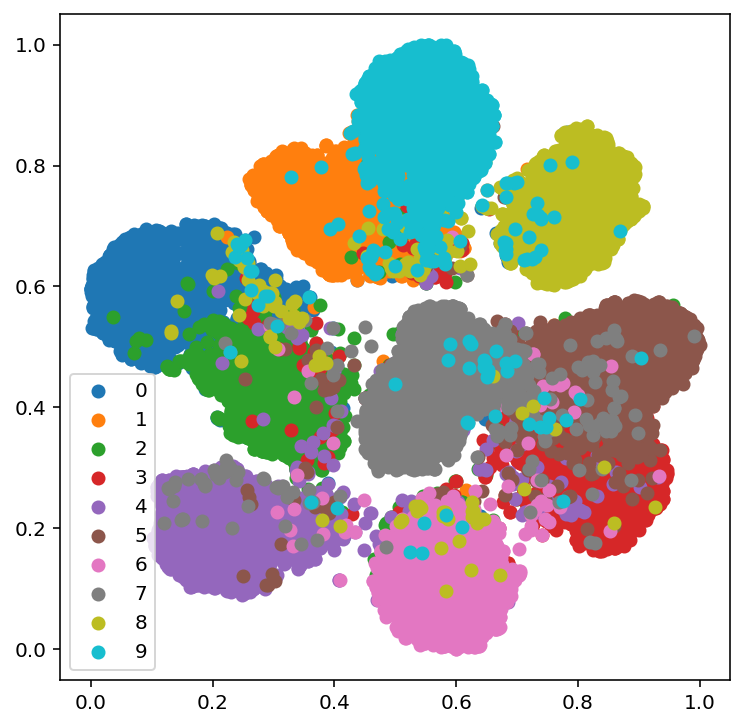

In [22]:
from sklearn.manifold import TSNE


tsne = TSNE()
images_cpu = [im.cpu().numpy().flatten() for im in images_db]
labels_cpu = [l.cpu().numpy().argmax() for l in labels_db]
X_embedded = tsne.fit_transform(np.array(images_cpu), np.array(labels_cpu))

plot_db(X_embedded, labels_cpu)